In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import yfinance as yf
from caviar import CaviarModel
from var_tests import *
import matplotlib.pyplot as plt

In [2]:
df = yf.download("AAPL JPM SPY XOM COKE", start="2001-01-01")

[*********************100%***********************]  5 of 5 completed


In [3]:
df_log_ret = df.Close.apply(np.log).diff().dropna() * 100
df_log_ret

,AAPL,COKE,JPM,SPY,XOM
Date,,,,,
2001-01-03,9.607481,0.339559,14.025589,4.691692,-4.445176
2001-01-04,4.112798,0.675678,2.679819,-1.082224,-2.825467
2001-01-05,-4.112798,1.669488,-6.069974,-3.318770,0.451468
2001-01-08,1.138456,3.257617,0.636539,0.771088,-0.451468
2001-01-09,3.704219,-3.092191,-1.148704,-0.264391,-1.061420
...,...,...,...,...,...
2023-04-03,0.767216,1.022637,-0.115172,0.380330,5.732553
2023-04-04,-0.325494,-3.910241,-1.345836,-0.556357,-0.960423
2023-04-05,-1.135451,2.323481,-0.632739,-0.262170,1.698245


## Emperical Analysis - Implementation (SPY)

In [4]:
quantiles = [0.01, 0.05]
models = ['adaptive', 'asymmetric', 'symmetric', 'igarch']
tickers = ['SPY'] # df_log_ret.columns

Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 342.9772008522902
Update 1: 0.04110224197557181
Update 2: 0.04110224197557181
Final loss: 0.04110224197557181
Time taken(s): 0.45
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 1.3972241521235687
Update 1: 0.033471578396713476
Update 2: 0.03347157838810581
Final loss: 0.03347157838810581
Time taken(s): 2.74
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 4.269101604960626
Update 1: 0.035014150921050764
Update 2: 0.034449754341800025
Update 3: 0.0344497543349774
Final loss: 0.0344497543349774
Time taken(s): 1.83
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 0.10196211185531275
Update 1: 0.03442518858771003
Update 2: 0.03442518858771003
Final loss: 0.03442518858771003
Time taken(s): 1.50
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 170.71339699572562
Update 1: 0.12817363709103974
Up

D:\CAViaR-Project\notebook-test\..\caviar\_utils.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))


Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 0.1637956660645
Update 1: 0.12624961396283763
Update 2: 0.126249422930917
Update 3: 0.1262494229258951
Final loss: 0.1262494229258951
Time taken(s): 1.49


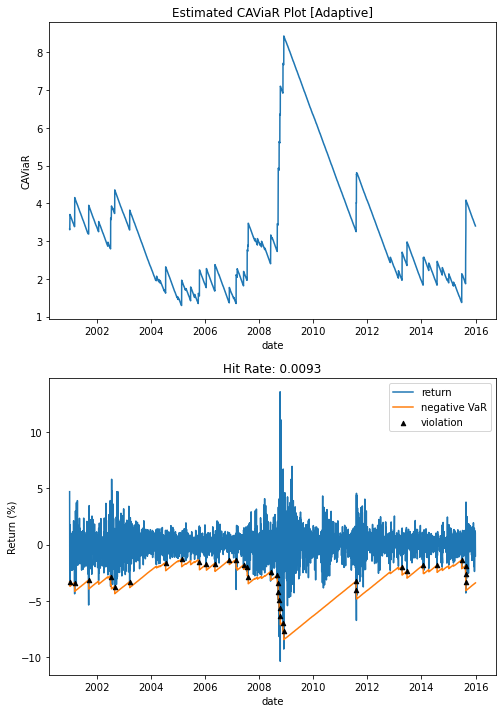

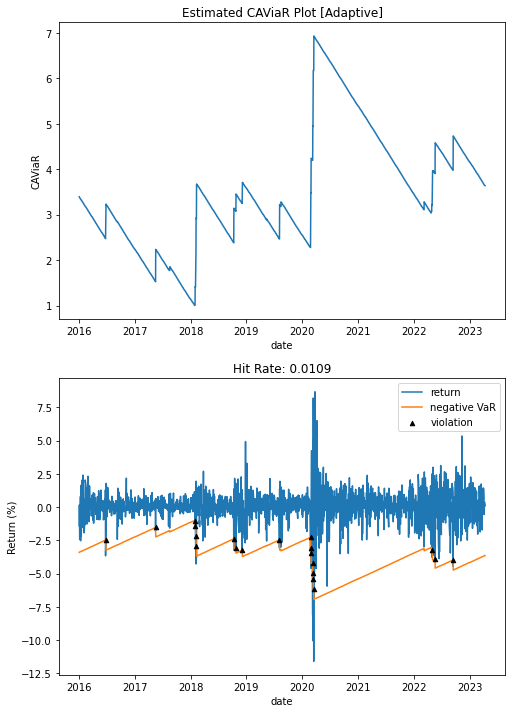

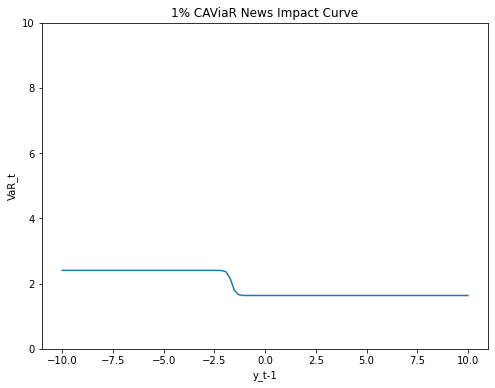

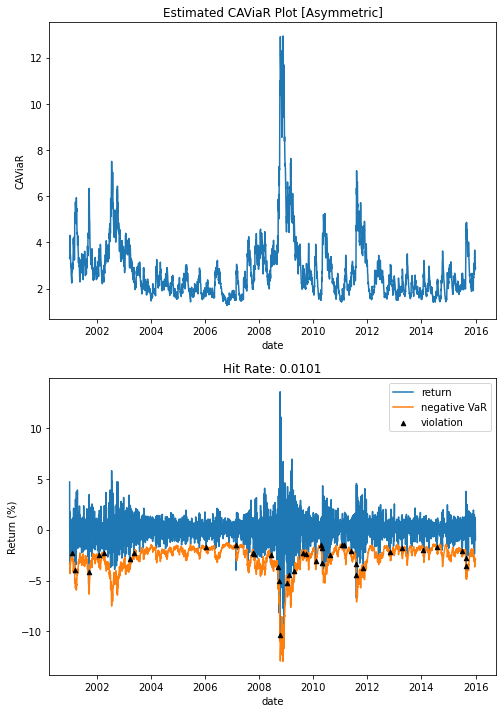

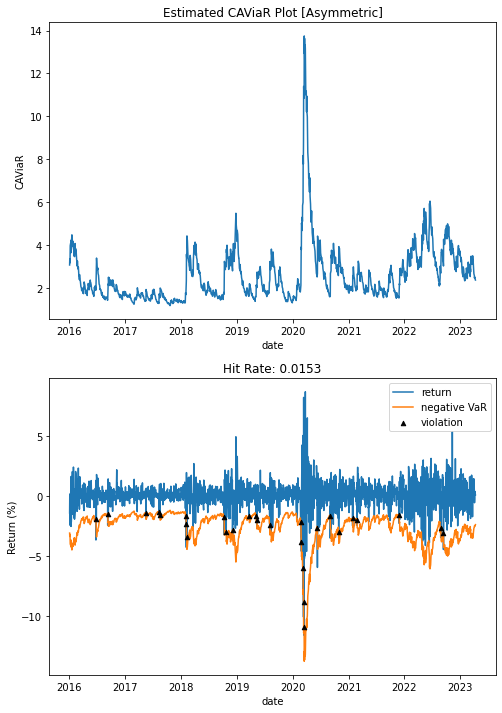

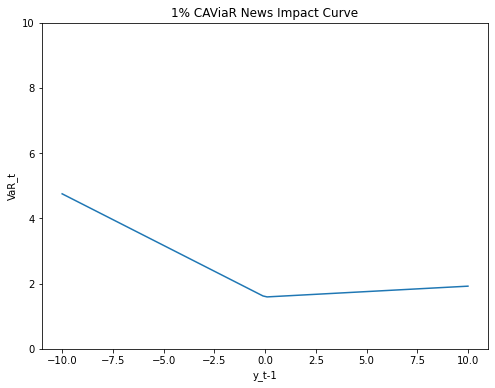

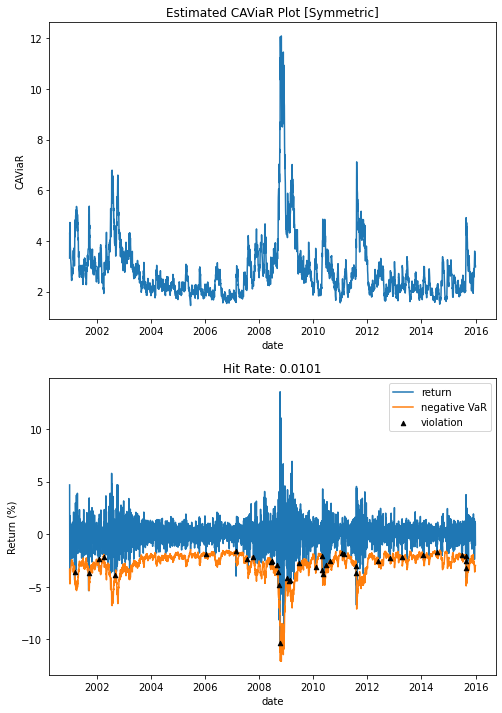

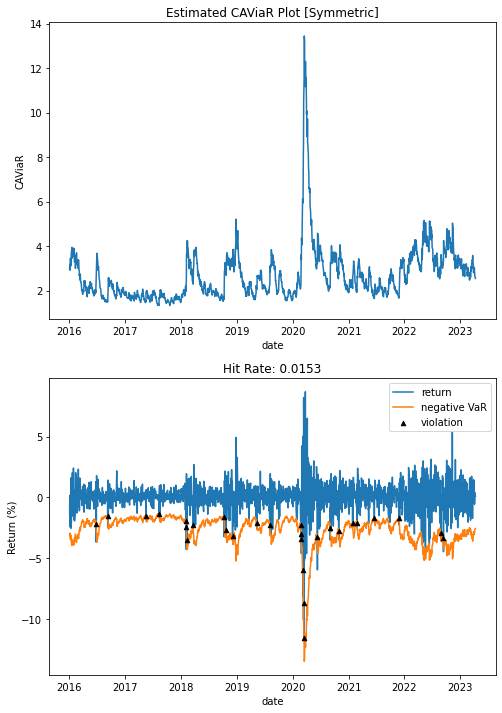

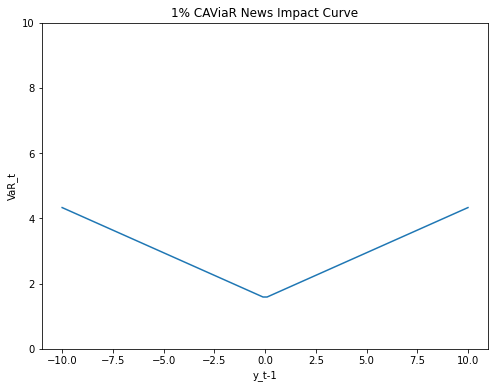

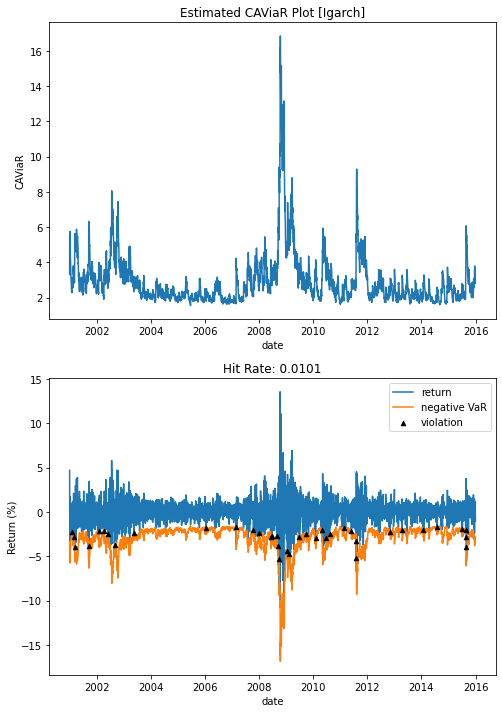

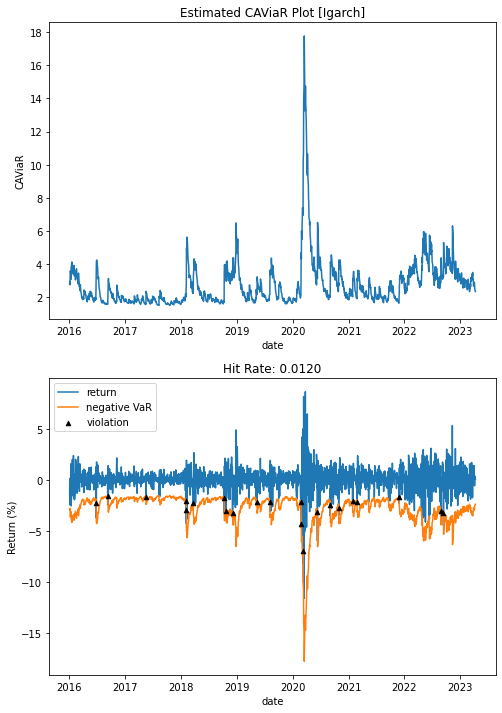

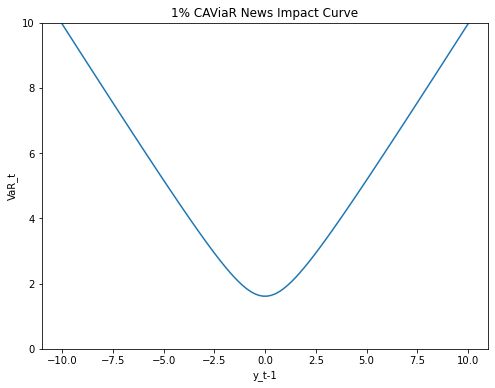

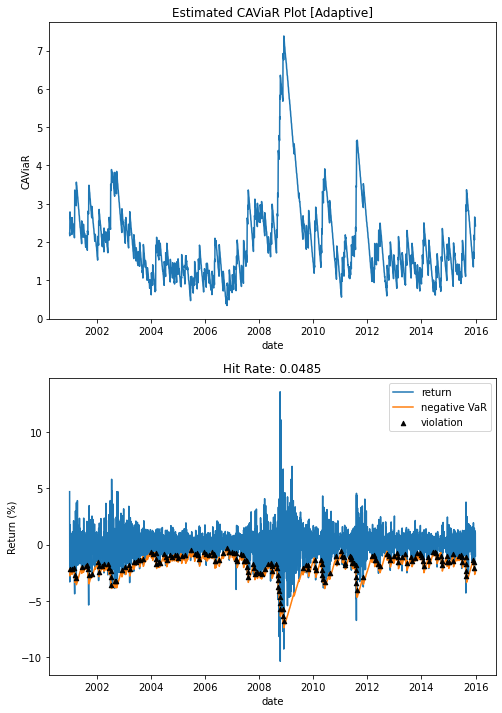

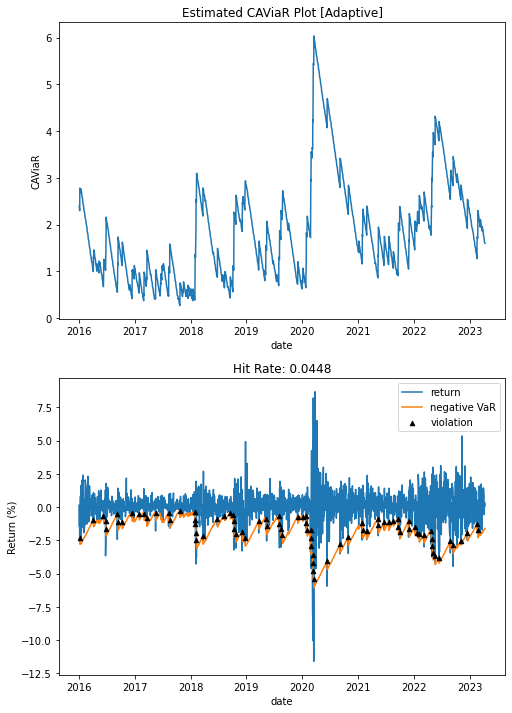

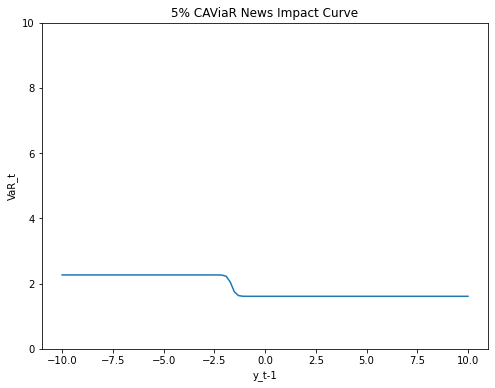

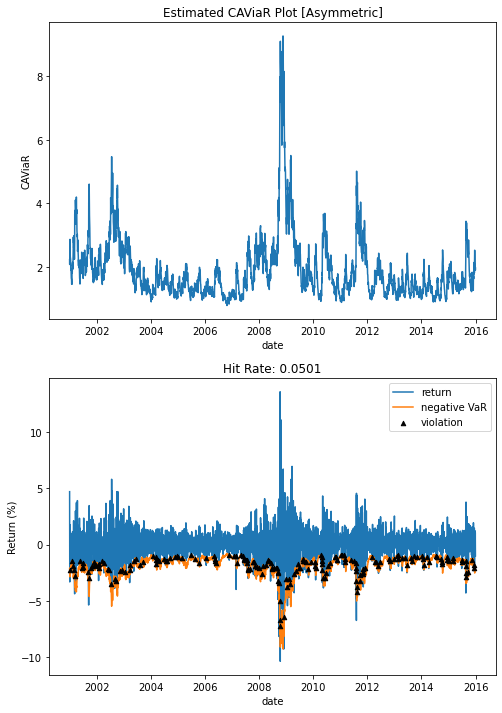

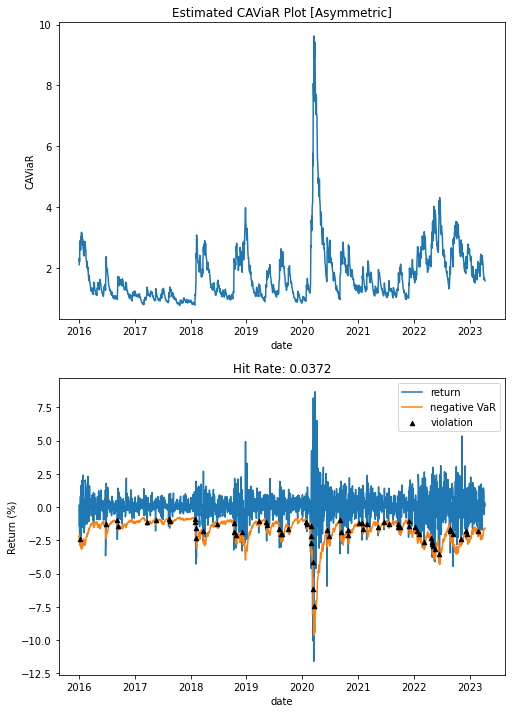

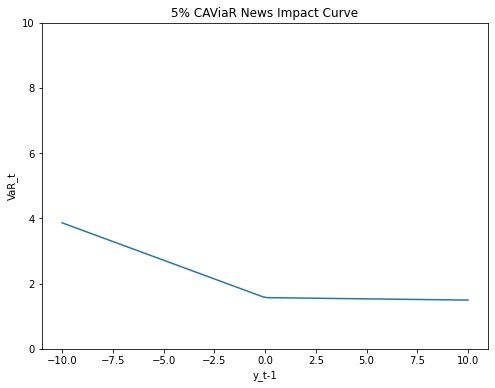

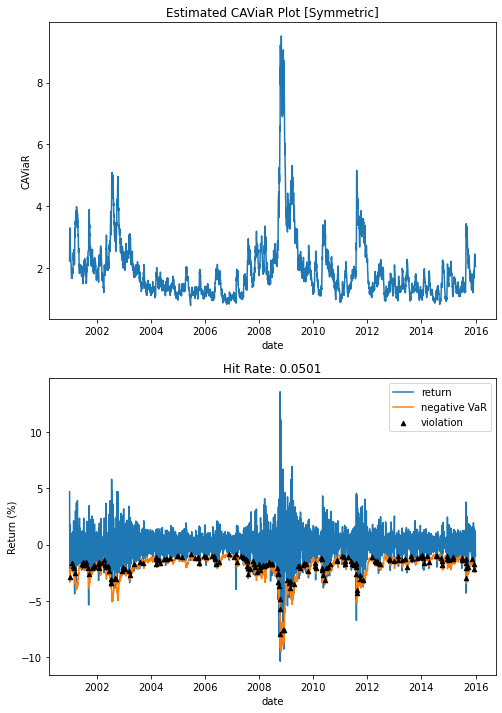

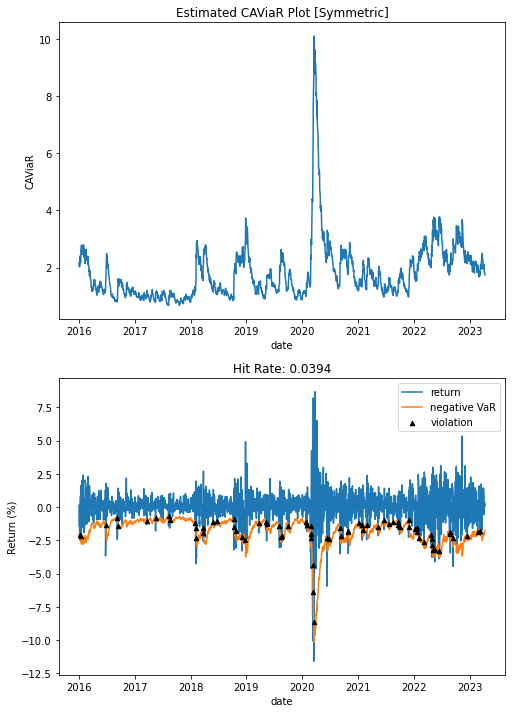

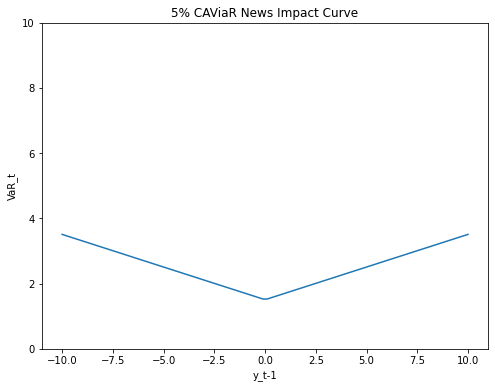

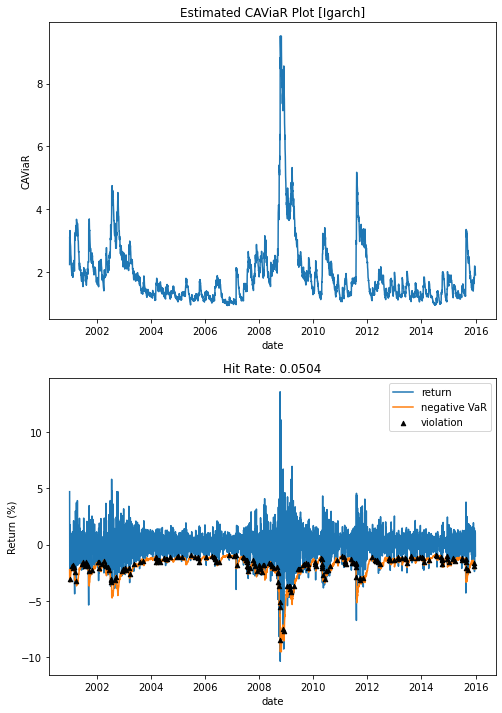

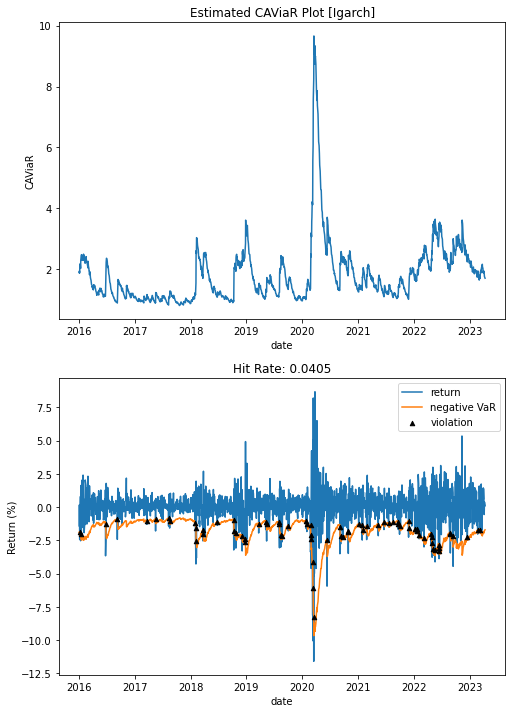

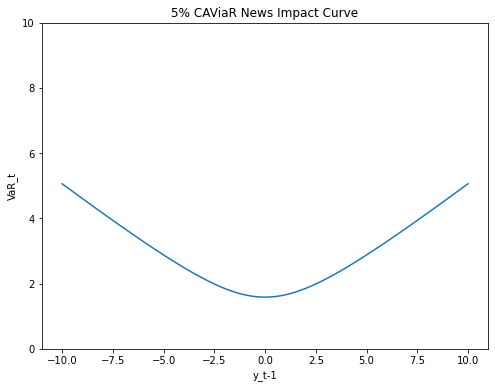

In [10]:
stats_df = []
beta_stats_df = []

save_csv_path = '../result/implementation1_spy'
save_plot_path = '../result/implementation1_spy/plots'

for ticker in tickers:
    in_samples = df_log_ret.loc[:'2015', ticker]
    out_samples = df_log_ret.loc['2016':, ticker]
    
    for q in quantiles:
        for model in models:
            caviar_model = CaviarModel(quantile=q, model=model, method='RQ')
            caviar_model.fit(in_samples)
            
            # save plots
            fig1 = caviar_model.plot_caviar(in_samples, 'in')
            plt.savefig(f'{save_plot_path}/{model}_{int(q*100)}%_plt_caviar_in.jpg')
            fig2 = caviar_model.plot_caviar(out_samples, 'out')
            plt.savefig(f'{save_plot_path}/{model}_{int(q*100)}%_plt_caviar_out.jpg')
            fig3 = caviar_model.plot_news_impact_curve()
            plt.savefig(f'{save_plot_path}/{model}_{int(q*100)}%_plt_news_impact_curve.jpg')
                        
            # as the last prediction is the VaR forecast
            in_VaR = caviar_model.predict(in_samples, 'in')[:-1]
            out_VaR = caviar_model.predict(out_samples, 'out')[:-1]

            # statistics
            stat = {
                'quantile': q,
                'model': model,
                'method': 'RQ',
                # 'trial': i,
                
                # insamples
                'loss': caviar_model.training_loss,
                'hit_rate_in': hit_rate(in_samples, in_VaR),
                'binom_in': binomial_test(in_samples, in_VaR, q),
                'traffic_in': traffic_light_test(in_samples, in_VaR, q)[0],
                'kupiec_in': kupiec_pof_test(in_samples, in_VaR, q),
                'independent_in': christoffersen_test(in_samples, in_VaR),
                'dq_in': caviar_model.dq_test(in_samples, 'in'),
                # outsamples
                'hit_rate_out': hit_rate(out_samples, out_VaR),
                'binom_out': binomial_test(out_samples, out_VaR, q),
                'traffic_out': traffic_light_test(out_samples, out_VaR, q)[0],
                'kupiec_out': kupiec_pof_test(out_samples, out_VaR, q),
                'independent_out': christoffersen_test(out_samples, out_VaR),
                'dq_out': caviar_model.dq_test(in_samples, 'in'),                
            }

            beta_stat = caviar_model.beta_summary()
            beta_stat['quantile'] = q
            beta_stat['model'] = model
            beta_stat['method'] = 'RQ'
            # beta_stat['trial'] = i

            stats_df.append(stat)
            beta_stats_df.append(beta_stat)

In [11]:
stats_df = pd.DataFrame(stats_df)
beta_stats_df = pd.concat(beta_stats_df)
beta_stats_df.index.name = 'beta'

In [18]:
stats_df.round(6)

,quantile,model,method,loss,hit_rate_in,binom_in,traffic_in,kupiec_in,independent_in,dq_in,hit_rate_out,binom_out,traffic_out,kupiec_out,independent_out,dq_out
0,0.01,adaptive,RQ,0.041102,0.009279,0.743131,green,0.652300,0.043261,0.0000,0.010935,0.637849,green,0.692187,0.000925,0.0000
1,0.01,asymmetric,RQ,0.033472,0.010074,0.934696,green,0.963498,0.400725,0.6824,0.015309,0.032976,green,0.034298,0.448312,0.6824
2,0.01,symmetric,RQ,0.034450,0.010074,0.934696,green,0.963498,0.060636,0.0067,0.015309,0.032976,green,0.034298,0.073612,0.0067
3,0.01,igarch,RQ,0.034425,0.010074,0.934696,green,0.963498,0.006198,0.0000,0.012028,0.347375,green,0.398159,0.265868,0.0000
4,0.05,adaptive,RQ,0.128174,0.048515,0.708729,green,0.674229,0.492380,0.3845,0.044833,0.334183,green,0.302462,0.038439,0.3845
5,0.05,asymmetric,RQ,0.124141,0.050106,0.970194,green,0.976168,0.870619,0.7051,0.037179,0.011540,green,0.008522,0.373206,0.7051
6,0.05,symmetric,RQ,0.126727,0.050106,0.970194,green,0.976168,0.609580,0.5805,0.039366,0.036275,green,0.030467,0.223424,0.5805
7,0.05,igarch,RQ,0.126249,0.050371,0.910748,green,0.916797,0.634444,0.1617,0.040459,0.060428,green,0.053155,0.037144,0.1617


In [17]:
beta_stats_df.round(6)

,coefficient,S.E. of beta,pval of beta,quantile,model,method
beta,,,,,,
beta1,-0.770349,0.119505,0.000000,0.01,adaptive,RQ
beta1,-0.074156,0.010609,0.000000,0.01,asymmetric,RQ
beta2,0.921956,0.008697,0.000000,0.01,asymmetric,RQ
beta3,-0.033249,0.052465,0.263124,0.01,asymmetric,RQ
beta4,0.316390,0.033309,0.000000,0.01,asymmetric,RQ
beta1,-0.123340,0.025890,0.000001,0.01,symmetric,RQ
beta2,0.875059,0.014273,0.000000,0.01,symmetric,RQ
beta3,-0.276983,0.026390,0.000000,0.01,symmetric,RQ
beta1,0.373373,0.108437,0.000287,0.01,igarch,RQ


In [ ]:
# save data
stats_df.T.round(6).to_csv(f'{save_csv_path}/experiment_stat_data_RQ_ppt.csv', header=None)
beta_stats_df.T.round(6).to_csv(f'{save_csv_path}/experiment_beta_stat_data_ppt.csv')